In [1]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import pandas as pd
import umap

In [2]:
# loading bag of ingredients represetation
boi = pd.read_csv('dataset/bag_of_ingre_w_cuisine.csv', index_col=0)
cuisines_df = pd.read_csv('dataset/Cuisines.csv', names=['cuisine'])

In [3]:
cuisines_df

,cuisine
1,Chinese
2,English
3,French
4,German
5,Greek
6,Indian
7,Italian
8,Japanese
9,Mexican
10,Moroccan


In [4]:
# make boi cuisine labels match actual cuisine labels
boi['cuisine'] = boi['cuisine'].transform(lambda x: x+1, axis=0)

We now have the bag of ingredients format of the data with the final column indicating the cuisine of the recipe

In [5]:
boi.head()

,acorn_squash,adobo,african_birdseye_chile_pepper,ale,aleppo_pepper,alfalfa_sprouts,alfredo_sauce,allspice,almond,almond_butter,...,yeast,yellow_curry_paste,yellow_food_coloring,yellow_split_pea,yellow_squash,yogurt,zaatar,zest,zucchini,cuisine
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Goal: Transform data suitable for PCA/UMAP

In order to perform a PCA or UMAP, we need to think of each ingredient as a dimension in a 709-dimensional vector space. 

Each cuisine will then be a point in this vector space that depends on the number of occurences each ingredient appears in that cuisine. For example, we could imagine the `Japanese` having a very high value in the `soy_sauce` dimension, whilst `English` would have a very low value.

In [6]:
# One line - it was that easy!
cuisine_ingredient_df = boi.groupby(['cuisine']).sum()

In [7]:
cuisine_ingredient_df.head()

,acorn_squash,adobo,african_birdseye_chile_pepper,ale,aleppo_pepper,alfalfa_sprouts,alfredo_sauce,allspice,almond,almond_butter,...,yams,yeast,yellow_curry_paste,yellow_food_coloring,yellow_split_pea,yellow_squash,yogurt,zaatar,zest,zucchini
cuisine,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,1,0,0,4,0,...,0,0,0,1,0,0,0,0,8,3
2,0,0,0,5,0,0,0,2,1,0,...,0,2,0,0,1,0,4,0,0,7
3,0,0,0,0,0,0,0,0,1,0,...,0,2,0,0,0,2,2,0,2,16
4,0,0,0,0,0,0,0,13,0,0,...,0,3,0,0,0,0,1,0,1,2
5,0,1,0,0,1,0,1,10,0,0,...,0,1,0,0,0,1,36,0,1,17


## PCA

In [8]:
from sklearn.decomposition import PCA

In [9]:
pca = PCA(n_components=2, whiten=True).fit(cuisine_ingredient_df)
pc_scores = pca.transform(cuisine_ingredient_df)

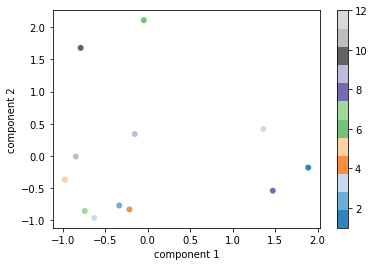

In [10]:
plt.scatter(pc_scores[:, 0], pc_scores[:, 1],
            c=cuisine_ingredient_df.index,
            edgecolor='none', alpha=1.0,
            cmap=plt.cm.get_cmap('tab20c', 12))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

In [11]:
pc_scores_df = pd.DataFrame(pc_scores, columns=['PC1', 'PC2'])
pc_scores_df.index +=1
pc_scores_df = pc_scores_df.join(cuisines_df)

In [12]:
pc_scores_df

,PC1,PC2,cuisine
1,1.888729,-0.184543,Chinese
2,-0.334168,-0.774083,English
3,-0.629816,-0.967433,French
4,-0.213829,-0.834945,German
5,-0.974968,-0.369606,Greek
6,-0.045506,2.110152,Indian
7,-0.739414,-0.859439,Italian
8,1.471811,-0.543803,Japanese
9,-0.151086,0.338575,Mexican
10,-0.788082,1.679693,Moroccan


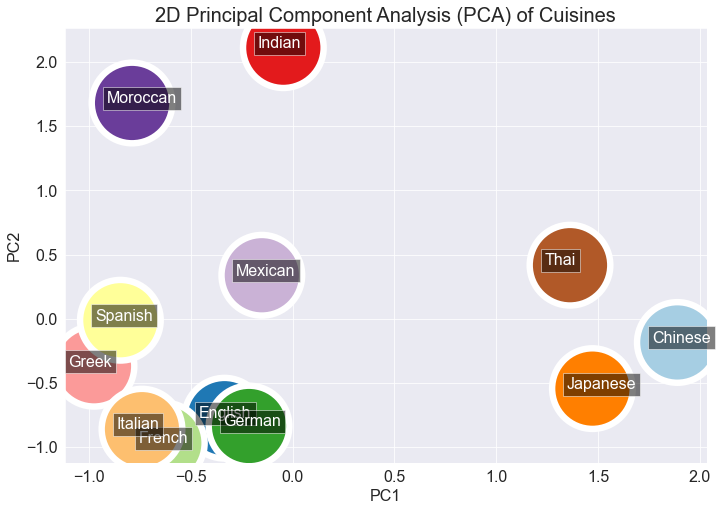

In [13]:
sns.set_style('darkgrid')
fig = plt.gcf()
fig.set_size_inches(11.5, 8)
title = "2D Principal Component Analysis (PCA) of Cuisines"
sns.scatterplot(data=pc_scores_df, 
                x='PC1', y='PC2', 
                hue="cuisine",
                s=6500,
                legend=False,
                palette=sns.color_palette('Paired')
                ).set_title(title, fontdict={'fontsize':20})
for i in range(1,pc_scores_df.shape[0]+1):
    plt.text(x=pc_scores_df.PC1[i]-0.125,
             y=pc_scores_df.PC2[i],
             s=pc_scores_df.cuisine[i],
             fontdict=dict(color='white',size=16),
             bbox=dict(facecolor='black', alpha=0.5))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('PC2', fontsize=16)
plt.xlabel('PC1', fontsize=16)
plt.savefig('imgs/cuisine_pca.png')
plt.show()

In [46]:
reducer = umap.UMAP(n_neighbors=4, transform_seed=1)
embedding = reducer.fit_transform(cuisine_ingredient_df)

In [47]:
embedding.shape

(12, 2)

In [48]:
umap_df = pd.DataFrame(embedding, columns=['Dim1', 'Dim2'])
umap_df.index +=1
umap_df = umap_df.join(cuisines_df)

In [49]:
umap_df.head()

,Dim1,Dim2,cuisine
1,-1.241948,5.393443,Chinese
2,2.054927,5.232860,English
3,2.710048,6.344806,French
4,2.320165,5.796000,German
5,1.916572,7.253829,Greek


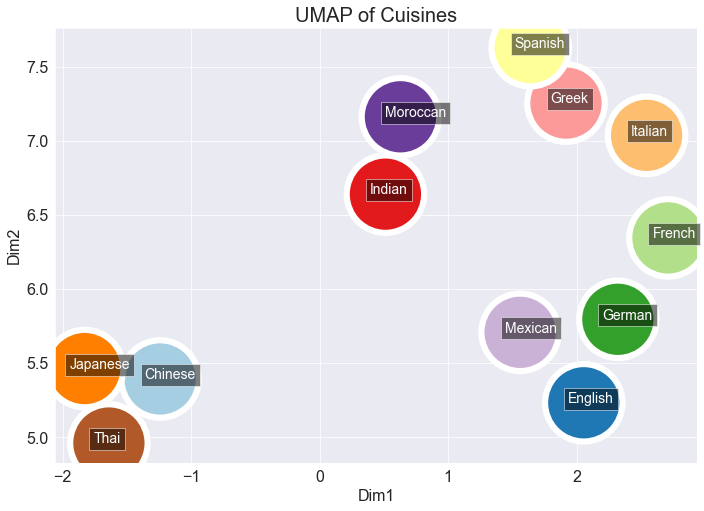

In [50]:
sns.set_style('darkgrid')
fig = plt.gcf()
fig.set_size_inches(11.5, 8)
title = "UMAP of Cuisines"
sns.scatterplot(data=umap_df, 
                x='Dim1', y='Dim2', 
                hue="cuisine",
                s=6000,
                legend=False,
                palette=sns.color_palette('Paired')
                ).set_title(title, fontdict={'fontsize':20})
for i in range(1,umap_df.shape[0]+1):
    plt.text(x=umap_df.Dim1[i]-0.12,
             y=umap_df.Dim2[i],
             s=umap_df.cuisine[i],
             fontdict=dict(color='white',size=14),
             bbox=dict(facecolor='black', alpha=0.5))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Dim2', fontsize=16)
plt.xlabel('Dim1', fontsize=16)
plt.savefig('imgs/cuisine_umap.png')
plt.show()